In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
data = pd.read_csv('/content/drive/My Drive/Toxic Comment/data.csv')
print('Shape of Data: ', data.shape)
data.head()

Shape of Data:  (159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
y_cols = list(data.columns[2:])
is_multilabel = (data[y_cols].sum(axis=1) >1).count()
print('is_multilabel count: ', is_multilabel)

is_multilabel count:  159571


In [5]:
data['non_toxic'] = 1-data[y_cols].max(axis=1)
y_cols += ['non_toxic']

In [6]:
from sklearn.model_selection import train_test_split
def get_train_test_val(data):
    X_data = data['comment_text'].values
    y_data = data[list(data.columns[2:])].values
    X, X_test, y, y_test = train_test_split(X_data, y_data, test_size=0.1, train_size=0.9)
    X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.25,train_size =0.75)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_val(data)

X_train shape (107709,) 
y_train shape (107709, 7) 
X_test shape (15958,) 
y_test shape (15958, 7) 
X_val shape (35904,) 
y_val shape (35904, 7)


In [7]:
X_train[0]

'Thanks! Please could you also check if the spell checker is enabled under Edit > Spelling and Grammar > Check Spelling While Typing.'

In [12]:
import nltk
import nltk as stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
REPLACE_IP_ADDRESS = re.compile(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b')

def text_prepare(text):
    text = text.replace('\n', ' ').lower()
    text = REPLACE_IP_ADDRESS.sub('', text) 
    text = REPLACE_BY_SPACE_RE.sub(' ',text)
    text = BAD_SYMBOLS_RE.sub('',text)
    text = ' '.join([w for w in text.split() if not w in STOPWORDS])
    return text

X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_train[:1]

['thanks please could also check spell checker enabled edit spelling grammar check spelling typing']

In [16]:
from scipy import sparse as sp_sparse

In [17]:
words_counts = {}
for comments in X_train:
    for word in comments.split():
        if word not in words_counts:
            words_counts[word] = 1
        words_counts[word] += 1
        
DICT_SIZE = 10000
POPULAR_WORDS = sorted(words_counts, key=words_counts.get, reverse=True)[:DICT_SIZE]
WORDS_TO_INDEX = {key: rank for rank, key in enumerate(POPULAR_WORDS, 0)}
INDEX_TO_WORDS = {index:word for word, index in WORDS_TO_INDEX.items()}
ALL_WORDS = WORDS_TO_INDEX.keys()


In [18]:
def my_bag_of_words(text, words_to_index, dict_size):
    result_vector = np.zeros(dict_size)
    for word in text.split(' '):
        if word in words_to_index:
            result_vector[words_to_index[word]] +=1
    return result_vector

X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
print('X_train shape ', X_train_mybag.shape, '\nX_val shape ', X_val_mybag.shape)

X_train shape  (107709, 10000) 
X_val shape  (35904, 10000)


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
def tfidf_features(X_train, X_val, X_test):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=5)
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_val_tfidf = tfidf_vectorizer.transform(X_val)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    
    return X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vectorizer.vocabulary_

X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [21]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

def train_classifier(X_train, y_train, C, regularisation):
    model = OneVsRestClassifier(LogisticRegression(penalty=regularisation, C=C, max_iter=10000)).fit(X_train, y_train)
    return model
classifier_mybag = train_classifier(X_train_mybag, y_train, C = 4, regularisation = 'l2')
classifier_tfidf = train_classifier(X_train_tfidf, y_train, C = 4, regularisation = 'l2')
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)

In [22]:
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

Text(69.0, 0.5, 'Actual_mybag')

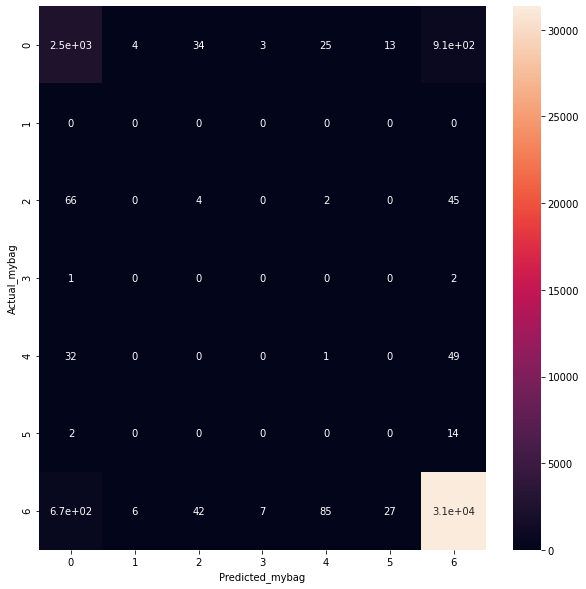

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(
    y_val.argmax(axis=1), y_val_predicted_labels_mybag.argmax(axis=1))

import seaborn as sns
plt.subplots(figsize=(10,10))
sns.heatmap(confusion_mat, annot=True)
plt.xlabel('Predicted_mybag')
plt.ylabel('Actual_mybag')

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [25]:
classifier_mybag = train_classifier(X_train_mybag, y_train, C = 50, regularisation = 'l2')
classifier_tfidf = train_classifier(X_train_tfidf, y_train, C = 50, regularisation = 'l2')

y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)

def print_evaluation_scores(y_test, predicted):
    
    print('Accuracy: ', accuracy_score(y_test, predicted, normalize=True))
    print('F1-score weighted: ', f1_score(y_test, predicted, average='weighted'))
    print('Precision weighted: ', average_precision_score(y_test, predicted, average='weighted'))
    print('Correctly Predicted words:',accuracy_score(y_test, predicted, normalize=False) )
    
print('Bag-of-words\n')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('\nTfidf\n')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words

Accuracy:  0.875445632798574
F1-score weighted:  0.9041761681035281
Precision weighted:  0.8629970297163784
Correctly Predicted words: 31432

Tfidf

Accuracy:  0.9107898841354723
F1-score weighted:  0.9212672406176565
Precision weighted:  0.8792982682239043
Correctly Predicted words: 32701


In [26]:
test_predictions = classifier_tfidf.predict(X_test_tfidf)

In [27]:
def get_pred_labels(data, predictions):
    y_cols = list(data.columns[2:])
    y_label_dict={}
    for k,v in enumerate(y_cols):
        y_label_dict[k] = v

    test_predictions_labels = []
    for pred in predictions:
        label_pred = []
        for index, label in enumerate(list(pred)):
            if label != 0:
                label = y_label_dict[index]
            label_pred.append(label)
        test_predictions_labels.append(tuple([i for i in label_pred if i != 0]))
    return test_predictions_labels

test_pred_labels = get_pred_labels(data, test_predictions)
test_labels = get_pred_labels(data, y_test)

In [28]:
for i in range(10,150):
    print('\ny_label: ', test_labels[i], '\ny_pred: ', test_pred_labels[i])
print('\ny_label: ', test_labels[i], '\ny_pred: ', test_pred_labels[i])


y_label:  ('non_toxic',) 
y_pred:  ('non_toxic',)

y_label:  ('non_toxic',) 
y_pred:  ('non_toxic',)

y_label:  ('non_toxic',) 
y_pred:  ('non_toxic',)

y_label:  ('non_toxic',) 
y_pred:  ('toxic',)

y_label:  ('toxic', 'obscene') 
y_pred:  ('non_toxic',)

y_label:  ('non_toxic',) 
y_pred:  ('non_toxic',)

y_label:  ('toxic',) 
y_pred:  ('toxic', 'obscene', 'insult')

y_label:  ('non_toxic',) 
y_pred:  ('non_toxic',)

y_label:  ('non_toxic',) 
y_pred:  ('non_toxic',)

y_label:  ('toxic',) 
y_pred:  ('non_toxic',)

y_label:  ('non_toxic',) 
y_pred:  ('non_toxic',)

y_label:  ('non_toxic',) 
y_pred:  ('non_toxic',)

y_label:  ('non_toxic',) 
y_pred:  ('non_toxic',)

y_label:  ('non_toxic',) 
y_pred:  ('non_toxic',)

y_label:  ('non_toxic',) 
y_pred:  ('non_toxic',)

y_label:  ('non_toxic',) 
y_pred:  ('non_toxic',)

y_label:  ('non_toxic',) 
y_pred:  ('non_toxic',)

y_label:  ('non_toxic',) 
y_pred:  ('non_toxic',)

y_label:  ('non_toxic',) 
y_pred:  ('non_toxic',)

y_label:  ('non_toxi